# Modern Convolutional Neural Network Architectures

We employ multilayer perceptron to pictures of clothing in the Fashion-MNIST dataset. Each image in Fashion-MNIST consisted of a two-dimensional 28 × 28 matrix. 

**LeNet5 - Convolutional Neural Networks**

These networks are built upon 3 main ideas: local receptive fields, shared weights and spacial subsampling. Local receptive fields with shared weights are the essence of the convolutional layer.

LeNet-5 is a very simple network. LeNet as consisting of two parts: (i) a block of convolutional layers; and (ii) a block of fully-connected layers. It only has 7 layers, among which there are 3 convolutional layers (C1, C3 and C5), 2 sub-sampling (pooling) layers (S2 and S4), and 1 fully connected layer (F6), that are followed by the output layer. Convolutional layers use 5 by 5 convolutions with stride 1. Sub-sampling layers are 2 by 2 average pooling layers. Tanh sigmoid activations are used throughout the network. 

*   ConvNet we alternate between convolutions, nonlinearities and often also pooling op- erations.
*   Ultimately the resolution is reduced prior to emitting an output via one (or more) dense layers.
*   LeNet uses weight decay.


In [0]:
!pip install mxnet
!pip install d2l

In [0]:
import d2l
import mxnet as mx
from mxnet import np, npx, nd, init, gluon, autograd
from mxnet.gluon import nn

npx.set_np()
mx.random.seed(1)
ctx = mx.cpu()

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        # Dense will transform the input of the shape (batch size, channel,
        # height, width) into the input of the shape (batch size,
        # channel * height * width) automatically by default
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))
net.initialize()

In [0]:
X = np.random.uniform(size=(1, 1, 28, 28))

In [0]:
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv4 output shape:	 (1, 6, 28, 28)
pool4 output shape:	 (1, 6, 14, 14)
conv5 output shape:	 (1, 16, 10, 10)
pool5 output shape:	 (1, 16, 5, 5)
dense6 output shape:	 (1, 120)
dense7 output shape:	 (1, 84)
dense8 output shape:	 (1, 10)


In [0]:
# Data Acquisition and Training
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [0]:
# Saved in the d2l package for later use
def evaluate_accuracy_gpu(net, data_iter, ctx=None):
    if not ctx:  # Query the first device the first parameter is on
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.as_in_context(ctx), y.as_in_context(ctx) # copy it to the GPU be- fore we can compute our models
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0]/metric[1]

In [0]:
# Saved in the d2l package for later use
def train_ch5(net, train_iter, test_iter, num_epochs, lr, ctx=d2l.try_gpu()):
  
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the only difference compared to train_epoch_ch3
            X, y = X.as_in_context(ctx), y.as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        train_loss, train_acc, test_acc))
    print('%.1f examples/sec on %s' % (metric[2]*num_epochs/timer.sum(), ctx))

loss 0.466, train acc 0.824, test acc 0.826
2689.4 examples/sec on cpu(0)


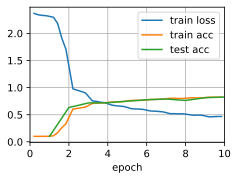

In [0]:
# Train the model based on Average-Pooling operation
lr, num_epochs = 0.9, 10
train_ch5(net, train_iter, test_iter, num_epochs, lr)

In [0]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        # Dense will transform the input of the shape (batch size, channel,
        # height, width) into the input of the shape (batch size,
        # channel * height * width) automatically by default
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))
net.initialize()

loss 0.407, train acc 0.849, test acc 0.841
2766.0 examples/sec on cpu(0)


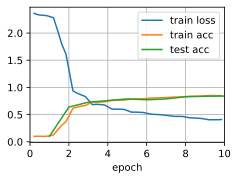

In [0]:
# Train the model based on Max-Pooling operation
lr, num_epochs = 0.9, 10
train_ch5(net, train_iter, test_iter, num_epochs, lr)

In [0]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output.as_nd_ndarray(), axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [0]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'conv6_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'conv6_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'conv7_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'conv7_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/usr/local/lib/python3.6/dist-packages/mxnet

In [0]:
# softmax cross-entropy loss
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [0]:
# optimizer 
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': .1})

In [0]:
epochs = 1
smoothing_constant = .01

for e in range(epochs):
    for i, (data, label) in enumerate(train_iter):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss.as_nd_ndarray()).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)

    test_accuracy = evaluate_accuracy(test_iter, net)
    train_accuracy = evaluate_accuracy(train_iter, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 0.3750154165983838, Train_acc 0.8651166666666666, Test_acc 0.863


In [0]:
# Layer summary
net.summary(data)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                             (96, 1, 28, 28)               0
        Activation-1                             (96, 6, 28, 28)               0
            Conv2D-2                             (96, 6, 28, 28)             156
         MaxPool2D-3                             (96, 6, 14, 14)               0
        Activation-4                            (96, 16, 10, 10)               0
            Conv2D-5                            (96, 16, 10, 10)            2416
         MaxPool2D-6                              (96, 16, 5, 5)               0
        Activation-7                                   (96, 120)               0
             Dense-8                                   (96, 120)           48120
        Activation-9                                    (96, 84)               0
            Dense-10        

**AlexNet**

AlexNet is much deeper than the comparatively small LeNet5. AlexNet consists of **eight layers**: five convolutional layers, two fully-connected hidden layers, and one fully-connected output layer. Second, AlexNet used the ReLU instead of the sigmoid as its activation function.

In AlexNetʼs first layer, the convolution window shape is 11 × 11. Since most images in ImageNet are more than ten times higher and wider than the MNIST images, objects in ImageNet data tend to occupy more pixels. Consequently, a larger convolution window is needed to capture the object. The convolution window shape in the second layer is reduced to 5×5, followed by 3×3. In addition, after the first, second, and fifth convolutional layers, the network adds maximum pooling layers with a window shape of 3 × 3 and a stride of 2. Moreover, AlexNet has 10 times more convolution channels than LeNet.

After the last convolutional layer are two fully-connected layers with 4096 outputs. These two huge fully-connected layers produce model parameters of nearly 1 GB. 

ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that back propagation cannot continue to update some of the model parameters. In contrast, the gradient of the ReLU activation function in the positive interval is always 1. Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, so that the model cannot be effectively trained.

 AlexNet controls the model complexity (i.e. Capacity Control) of the fully-connected layer by dropout, while LeNet only uses weight decay. 

In [0]:
# Build AlexNet architecture
net = nn.Sequential()
# Here, we use a larger 11 x 11 window to capture objects. At the same time,
# we use a stride of 4 to greatly reduce the height and width of the output.
# Here, the number of output channels is much larger than that in LeNet
net.add(nn.Conv2D(96, kernel_size=11, strides=4, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        nn.Conv2D(256, kernel_size=5, padding=2, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
        nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
        nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # Here, the number of outputs of the fully connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        nn.Dense(4096, activation="relu"), nn.Dropout(0.5),
        nn.Dense(4096, activation="relu"), nn.Dropout(0.5),
        # Output layer. Since we are using Fashion-MNIST, the number of
        # classes is 10, instead of 1000 as in the paper
        nn.Dense(10))
#net.initialize()

In [0]:
# We generate a single-channel data instance with both height and width of 224 to observe the out- put shape of each layer.)
X = np.random.uniform(size=(1, 1, 224, 224))

In [0]:
net.initialize()

In [0]:
# Print layer schematics
for layer in net:
    output = layer(X)
    print(layer.name, 'output shape:\t', output.shape)

conv0 output shape:	 (1, 96, 54, 54)
pool0 output shape:	 (1, 1, 111, 111)
conv1 output shape:	 (1, 256, 224, 224)
pool1 output shape:	 (1, 1, 111, 111)
conv2 output shape:	 (1, 384, 224, 224)
conv3 output shape:	 (1, 384, 224, 224)
conv4 output shape:	 (1, 256, 224, 224)
pool2 output shape:	 (1, 1, 111, 111)
dense0 output shape:	 (1, 4096)
dropout0 output shape:	 (1, 1, 224, 224)
dense1 output shape:	 (1, 4096)
dropout1 output shape:	 (1, 1, 224, 224)
dense2 output shape:	 (1, 10)


In [0]:
# Reading the Dataset
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

Compared to LeNet in the previous section, the main change here is the use of a smaller learning rate and much slower training due to the deeper and wider network, the higher image resolution and the more costly convolutions.

In [0]:
# Configure training loop
lr, num_epochs = 0.01, 10
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

In [0]:
# Layer summary
#net.summary(data)

**Visual Geometry Group (VGG)**

 Networks Using Blocks, VGG-11 constructs a network using reusable convolutional blocks. Different VGG model scan be defined by the differences in the number of convolutional layers and output channels in each block.
 
The use of blocks leads to very compact representations of the network definition. It allows for efficient design of complex networks.

One VGG block consists of a sequence of convolutional layers, followed by a max pooling layer for spatial downsampling. VGG mploys convolutions with 3 × 3 kernels and 2 × 2 max pooling with stride of 2 (halving the res- olution after each block). The fully-connected module is identical to that covered in AlexNet.

In [0]:
def vgg_block(num_convs, num_channels):
    blk = nn.Sequential()
    for _ in range(num_convs):
        blk.add(nn.Conv2D(num_channels, kernel_size=3,
                          padding=1, activation='relu'))
    blk.add(nn.MaxPool2D(pool_size=2, strides=2))
    return blk

The original VGG network had 5 convolutional blocks, among which the first two have one convo- lutional layer each and the latter three contain two convolutional layers each. The first block has 64 output channels and each subsequent block doubles the number of output channels, until that number reaches 512. Since this network uses 8 convolutional layers and 3 fully-connected layers, it is often called VGG-11.

In [0]:
# 5 convolutional tuple blocks: (number of convolution layers, number of output channels)
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [0]:
# VGG-11 implementation
def vgg(conv_arch):
    net = nn.Sequential()
    # The convolutional layer part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully connected layer part
    net.add(nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
            nn.Dense(4096, activation='relu'), nn.Dropout(0.5),
            nn.Dense(10))
    return net

In [0]:
net = vgg(conv_arch)
net.initialize()

In [0]:
X = np.random.uniform(size=(1, 1, 224, 224))

In [0]:
for blk in net:
   X = blk(X)
   print(blk.name, 'output shape:\t', X.shape) 

sequential1 output shape:	 (1, 64, 112, 112)
sequential2 output shape:	 (1, 128, 56, 56)
sequential3 output shape:	 (1, 256, 28, 28)
sequential4 output shape:	 (1, 512, 14, 14)
sequential5 output shape:	 (1, 512, 7, 7)
dense0 output shape:	 (1, 4096)
dropout0 output shape:	 (1, 4096)
dense1 output shape:	 (1, 4096)
dropout1 output shape:	 (1, 4096)
dense2 output shape:	 (1, 10)


In [0]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

Apart from using a slightly larger learning rate, the model training process is similar to that of AlexNet in the last section.

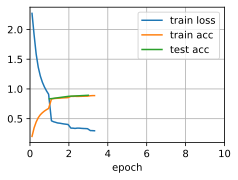

In [0]:
lr, num_epochs, batch_size = 0.05, 10, 128,
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

**Network in Network (NiN)**

Network in Network (NiN) blocks offer an alternative, based on a very simple insight—to use an MLP on the channels for each pixel separately. The idea behind NiN is to apply a fully-connected layer at each pixel location (for each height and width)

NiN uses blocks consisting of a convolutional layer and multiple 1 × 1 convolutional layer. This can be used within the convolutional stack to allow for more per-pixel nonlinearity.

The NiN block consists of one convolutional layer followed by two 1 × 1 convolutional layers that act as per-pixel fully-connected layers with ReLU activations. The convolution width of the first layer is typically pre-set. The subsequent widths are fixed to 1 × 1.

NiN uses convolutional layers with window shapes of 11×11, 5×5, and 3×3, and the corresponding numbers of output channels are the same as in AlexNet. Each NiN block is followed by a maximum pooling layer with a stride of 2 and a window shape of 3 × 3.

NiN removes the fully connected layers and replaces them with global average pooling(i.e., summing over all locations) after reducing the number of channels to the desired number of outputs (e.g. 10 for Fashion-MNIST). Removing the dense layers reduces overfitting. NiN has dramatically fewer parameters.

Note: the inputs and outputs of convolutional layers consist of 4-dimensional arrays with axes corresponding to the batch, channel, height, and width. While the inputs and outputs of fully-connected layers are typically 2-dimensional arrays corresponding to the batch, and features.

In [0]:
def nin_block(num_channels, kernel_size, strides, padding):
    blk = nn.Sequential()
    blk.add(nn.Conv2D(num_channels, kernel_size, strides, padding,
                      activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'),
            nn.Conv2D(num_channels, kernel_size=1, activation='relu'))
    return blk

Once significant difference between NiN and AlexNet is that NiN avoids dense connections altogether. Instead, NiN uses an NiN block with a number of output channels equal to the number of label classes, followed by a global average pooling layer, yielding a vector of logits

In [0]:
net = nn.Sequential()
net.add(nin_block(96, kernel_size=11, strides=4, padding=0),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(256, kernel_size=5, strides=1, padding=2),
        nn.MaxPool2D(pool_size=3, strides=2),
        nin_block(384, kernel_size=3, strides=1, padding=1),
        nn.MaxPool2D(pool_size=3, strides=2),
        nn.Dropout(0.5),
        # There are 10 label classes
        nin_block(10, kernel_size=3, strides=1, padding=1),
        # The global average pooling layer automatically sets the window shape
        # to the height and width of the input
        nn.GlobalAvgPool2D(),
        # Transform the four-dimensional output into two-dimensional output
        # with a shape of (batch size, 10)
        nn.Flatten())
net.initialize()

In [0]:
X = np.random.uniform(size=(1, 1, 224, 224))

In [0]:
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

NiNʼs training is similar to that for AlexNet and VGG, but it often uses a larger learning rate.

In [0]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

**GoogLeNet - Inception Blocks**

GoogleLeNet proposes a structure that combined the strengths of the NiN and repeated blocks paradigms. And it takes advantage of combinating various-sized kernels. The basic convolutional block in GoogLeNet is called an Inception block.

The inception block consists of four parallel paths. The first three paths use convolutional layers with window sizes of 1 × 1, 3 × 3, and 5 × 5 to extract information from different spatial sizes. The middle two paths perform a 1 × 1 convolution on the input to reduce the number of input channels, reducing the modelʼs complexity. The fourth path uses a 3 × 3 maximum pooling layer, followed by a 1 × 1 convolutional layer to change the number of channels. The four paths all use appropriate padding to give the input and output the same height and width. 

Finally, the outputs along each path are concatenated along the channel dimension and comprise the blockʼs output. The commonly-tuned parameters of the Inception block are the number of output channels per layer.

The Inception block is equivalent to a subnetwork with four paths. It extracts information in parallel through convolutional layers of different window shapes and maximum pooling layers. 1 × 1 convolutions reduce channel dimensionality on a per-pixel level. Max-pooling reduces the resolution.

In [0]:
class Inception(nn.Block):
    # c1 - c4 are the number of output channels for each layer in the path
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1,
                              activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2,
                              activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')
    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return np.concatenate((p1, p2, p3, p4), axis=1)

GoogLeNet uses a stack of a total of 9 inception blocks and global average pooling to generate its estimates. (GoogLeNet uses four blocks made up of Inception blocks.?)

Maximum pooling between inception blocks reduced the dimensionality. The first part is identical to AlexNet and LeNet, the stack of blocks is inherited from VGG and the global average pooling avoids a stack of fully-connected layers at the end (similar to NiN).

The first component uses a 64-channel 7×7 convolutional layer.

In [0]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

The second component uses two convolutional layers: first, a 64-channel 1 × 1 convolutional layer, then a 3×3 convolutional layer that triples the number of channels. This corresponds to the second path in the Inception block.

In [0]:
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
       nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

The third component connects two complete Inception blocks in series. 

The number of output channels of the first Inception block is 64 + 128 + 32 + 32 = 256, and the ratio to the output channelsofthefourpathsis64 : 128 : 32 : 32 = 2 : 4 : 1 : 1. Thesecondandthirdpathsfirst reduce the number of input channels to 96/192 = 1/2 and 16/192 = 1/12, respectively, and then connect the second convolutional layer. The number of output channels of the second Inception block is increased to 128 + 192 + 96 + 64 = 480, and the ratio to the number of output channels per path is 128 : 192 : 96 : 64 = 4 : 6 : 3 : 2. The second and third paths first reduce the number of input channels to 128/256 = 1/2 and 32/256 = 1/8, respectively.


In [0]:
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

The fourth block is more complicated. It connects five Inception blocks in series, and they have 192+208+48+64 = 512, 160+224+64+64 = 512, 128+256+64+64 = 512, 112+288+64+64 = 528, and 256+320+128+128 = 832 output channels, respectively. The number of channels assigned to these paths is similar to that in the third module: the second path with the 3×3 convolutional layer outputs the largest number of channels, followed by the first path with only the 1 × 1 convolutional layer, the third path with the 5×5 convolutional layer, and the fourth path with the 3×3 maximum pooling layer. The second and third paths will first reduce the number of channels according the ratio. These ratios are slightly different in different Inception blocks.

In [0]:
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

The fifth block has two Inception blocks with 256+320+128+128 = 832 and 384+384+128+128 = 1024 output channels. The number of channels assigned to each path is the same as that in the third and fourth modules, but differs in specific values. It should be noted that the fifth block is followed by the output layer. This block uses the global average pooling layer to change the height and width of each channel to 1, just as in NiN. Finally, we turn the output into a two-dimensional array followed by a fully-connected layer whose number of outputs is the number of label classes.

In [0]:
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())

In [0]:
net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

In [0]:
net.initialize()

In [0]:
X = np.random.uniform(size=(1, 1, 96, 96))

In [0]:
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

We transform it to 96 × 96 pixel resolution before invoking the training procedure.

In [0]:
# Data Acquisition and Training
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96) # To have a reasonable training time on Fashion-MNIST by reducing the input height and width from 224 to 96
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

**Batch Normalization**

It is precisely due to this normalization based on batch statistics that batch normalization derives its name. One takeaway here is that when applying BN, the choice of minibatch size may be even more significant than without BN.

The activation magnitudes for intermediate layers cannot diverge during training because BN actively centers and rescales them back to a given mean and size (via μ and σ). After applying BN, the resulting minibatch of activations has zero mean and unit variance.

BN seems to allows for more aggressive learning rates.  BN works best for moderate minibatches sizes in the 50–100 range. Preliminary research relate the properties of BN to Bayesian Priors and penalties respectively. BN layers function differently in training mode (normalizing by minibatch statistics) and in prediction mode (normalizing by dataset statistics).



In [0]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use autograd to determine whether the current mode is training mode or
    # prediction mode
    if not autograd.is_training():
        # If it is the prediction mode, directly use the mean and variance
        # obtained from the incoming moving average
        X_hat = (X - moving_mean) / np.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(axis=0)
            var = ((X - mean) ** 2).mean(axis=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcast operation
            # can be carried out later
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = ((X - mean) ** 2).mean(axis=(0, 2, 3), keepdims=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / np.sqrt(var + eps)
        # Update the mean and variance of the moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean, moving_var

Typically, after training, we use the entire dataset to compute stable estimates of the activation statistics and then fix them at prediction time. Consequently, BN behaves differently during train- ing and at test time. First, the noise in μ and σ arising from estimating each on minibatches are no longer desirable once we have trained the model.

Typically, we define the math in a separate function, say batch_norm. We then inte- grate this functionality into a custom layer, whose code mostly addresses bookkeeping matters, such as moving data to the right device context, allocating and initializing any required variables, keeping track of running averages (here for mean and variance), etc. This pattern enables a clean separation of math from boilerplate code. 

In [0]:
class BatchNorm(nn.Block):
    def __init__(self, num_features, num_dims, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter involved in gradient
        # finding and iteration are initialized to 0 and 1 respectively
        self.gamma = self.params.get('gamma', shape=shape, init=init.One())
        self.beta = self.params.get('beta', shape=shape, init=init.Zero())
        # All the variables not involved in gradient finding and iteration are
        # initialized to 0 on the CPU
        self.moving_mean = np.zeros(shape)
        self.moving_var = np.zeros(shape)
    def forward(self, X):
        # If X is not on the CPU, copy moving_mean and moving_var to the
        # device where X is located
        if self.moving_mean.context != X.context:
            self.moving_mean = self.moving_mean.copyto(X.context)
            self.moving_var = self.moving_var.copyto(X.context)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma.data(), self.beta.data(), self.moving_mean,
            self.moving_var, eps=1e-12, momentum=0.9)
        return Y

In [0]:
# Using a Batch Normalization LeNet
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        BatchNorm(6, num_dims=4),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        BatchNorm(16, num_dims=4),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        BatchNorm(120, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        BatchNorm(84, num_dims=2),
        nn.Activation('sigmoid'),
        nn.Dense(10))

In [0]:
# we use a considerably larger learning rate due to using Batch-Norm layer
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

In [0]:
# Let's look at the scale parameter gamma and the shift parameter beta learned from the first batch normalization layer.
print(net[1].gamma.data().reshape(-1,))
print(net[1].beta.data().reshape(-1,))

In [0]:
# Batch-Norm layer using Gluon implementaiton
net = nn.Sequential()
net.add(nn.Conv2D(6, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Dense(120),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(84),
        nn.BatchNorm(),
        nn.Activation('sigmoid'),
        nn.Dense(10))

In [0]:
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

**Residual Networks(ResNet)**

At the heart of ResNet is the idea that every additional layer should contain the identity function as one of its elements. 

This means that if we can train the newly-added layer into an identity mapping f(x) = x, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors. Even better, the identity function rather than the null f(x) = 0 should be the the simplest function within a layer.

The main architecture of ResNet is similar to that of GoogLeNet, ResNetʼs structure is simpler and easier to modify.

In [0]:
# Saved in the d2l package for later use
class Residual(nn.Block):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1, strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
          self.conv3 = nn.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
          self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
      Y = npx.relu(self.bn1(self.conv1(X)))
      Y = self.bn2(self.conv2(Y))
      if self.conv3:
        X = self.conv3(X)
      return npx.relu(Y + X)

In [0]:
blk = Residual(3)
blk.initialize()

In [0]:
X = np.random.uniform(size=(4, 3, 6, 6))

In [0]:
blk(X).shape

In [0]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk.initialize()
blk(X).shape

In [0]:
def resnet_block(num_channels, num_residuals, first_block=False):
    blk = nn.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk


The first two layers of ResNet are the same as those of the GoogLeNet we described before: the 7×7 convolutional layer with 64 output channels and a stride of 2 is followed by the 3×3 maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

ResNet uses 4 modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. The number of channels is doubled compared with that of the previous module, and the height and width are halved.

In [0]:
# ResNet-18 Model
num_residuals=2

net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
net.add(resnet_block(64, num_residuals, first_block=True),
        resnet_block(128, num_residuals),
        resnet_block(256, num_residuals),
        resnet_block(512, num_residuals))

There are 4 convolutional layers (2 num_residuals x resnet_block with 2 convolutional layers) in each module (excluding the 1 × 1 convolutional layer). To- gether with the first convolutional layer and the final fully connected layer, there are 18 layers in total. 

In [0]:
net.add(nn.GlobalAvgPool2D(), nn.Dense(10))

In [0]:
net.initialize()

In [0]:
X = np.random.uniform(size=(1, 1, 224, 224))

In [0]:
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

In [0]:
# Data Acquisition and Training
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)

**Densely Connected Networks(DenseNet)**

ResNet significantly changed the view of how to parametrize the functions in deep networks. DenseNet is to some extent the logical extension of this. The main difference between ResNet (left) and DenseNet (right) in cross-layer connec- tions: use of addition and use of concatenation.

The main components that compose a DenseNet are dense blocks and transition layers. The former defines how the inputs and outputs are concatenated, while the latter controls the number of channels so that it is not too large. 

DenseNet uses the modified “batch normalization, activation, and convolution” architecture of ResNet

In [0]:
# Dense Blocks
def conv_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(),
            nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=3, padding=1))
    return blk

A dense block consists of multiple conv_block units, each using the same number of output chan- nels. In the forward computation, however, we concatenate the input and output of each block on the channel dimension.

The number of convolution block channels controls the increase in the number of output channels relative to the number of input channels. This is also referred to as the growth rate.


In [0]:
class DenseBlock(nn.Block):
    def __init__(self, num_convs, num_channels, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.net = nn.Sequential()
        for _ in range(num_convs):
            self.net.add(conv_block(num_channels))
    def forward(self, X):
      for blk in self.net:
        Y = blk(X)
        # Concatenate the input and output of each block on the channel
        # dimension
        X = np.concatenate((X, Y), axis=1)
      
      return X

In [0]:
blk = DenseBlock(2, 10)
blk.initialize()

In [0]:
X = np.random.uniform(size=(4, 3, 8, 8))
Y = blk(X)
Y.shape

(4, 23, 8, 8)

**Transition Layers**

Since each dense block will increase the number of channels, adding too many of them will lead to an excessively complex model. A transition layer is used to control the complexity of the model. It reduces the number of channels by using the 1 × 1 convolutional layer and halves the height and width of the average pooling layer with a stride of 2, further reducing the complexity of the model.

In [0]:
# Transition Layers
def transition_block(num_channels):
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(), nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=1),
            nn.AvgPool2D(pool_size=2, strides=2))
    return blk

DenseNet uses four dense blocks. Sim- ilar to ResNet, we can set the number of convolutional layers used in each dense block. Here, we set it to 4, consistent with the ResNet-18. Furthermore, we set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In [0]:
# DenseNet Model
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

In ResNet, the height and width are reduced between each module by a residual block with a stride of 2. Here, we use the transition layer to halve the height and width and halve the number of channels.

In [0]:
# Num_channels: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]

In [0]:
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    net.add(DenseBlock(num_convs, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        num_channels //= 2
        net.add(transition_block(num_channels))

Similar to ResNet, a global pooling layer and fully connected layer are connected at the end to produce the output.

In [0]:
net.add(nn.BatchNorm(),
        nn.Activation('relu'),
        nn.GlobalAvgPool2D(),
        nn.Dense(10))

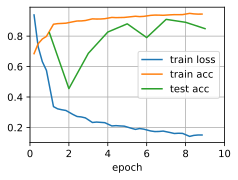

In [0]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_s ize, resize=96)
d2l.train_ch5(net, train_iter, test_iter, num_epochs, lr)